## Import Dependencies And Define Paths

In [1]:
import numpy as np 
import pandas as pd  
# %matplotlib inline
import matplotlib.pyplot as plt
from itertools import chain
from keras.preprocessing.image import ImageDataGenerator 
from sklearn.metrics import roc_curve, auc
import keras
import tensorflow as tf


In [2]:
# Mount your google drive to access the files 
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
# Import Data Files 
rtrain =pd.read_csv("/content/drive/MyDrive/NIH-CXR/train_set.csv")
rtest = pd.read_csv("/content/drive/MyDrive/NIH-CXR/test_set.csv")
rval = pd.read_csv("/content/drive/MyDrive/NIH-CXR/val_set.csv")

In [4]:
def path_fix(df, column, header):
  copy_df = df.copy()
  # Insert the header path for your drive folder
  copy_df[column] = header + copy_df[column].astype(str)
  # Replace the backslashes with forward slashes as a string. \\\\ is for regex purposes
  copy_df[column] = copy_df[column].str.replace("\\\\", "/")
    
  return copy_df

In [5]:
# Function to clean the sets and extract the labels. 

def label_cleaner(raw_df):
    # Copy the Df into two separate dataframes, one for saving as csv and one for output
    copy_df = raw_df.copy()

    # Create a column for categorical labels list in case of use
    copy_df["Labels"] = copy_df["Finding Labels"].replace("No Finding", "").str.split("|", expand = False)
    # Get a list of all diseases 
    di = list(chain(*copy_df["Finding Labels"].replace("No Finding", "").str.split("|", expand = False).tolist()))
    # Drop unnecessary columns from df 
    copy_df.drop(columns = ['Unnamed: 0', 'og_idx'], axis= 1, inplace= True )

    #Extract the list of diseases as a regualr list and as an numpy array because the model likes arrays    
    ls = np.unique(di).tolist()
    ls.remove('')
    np_ls = np.array(ls)

    return copy_df, ls, np_ls


In [6]:
# Define constants for the column name and the path header. 
COL = "path"
HEAD = "/content/drive/MyDrive/NIH-CXR/"

In [7]:
# Fix the paths specific to google drive format 
ftrain = path_fix(rtrain, COL, HEAD)
ftest = path_fix(rtest, COL, HEAD)
fval = path_fix(rval, COL, HEAD)

ftrain.head()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: FutureWarning: The default value of regex will change from True to False in a future version.
  


,Unnamed: 0,og_idx,Image Index,Finding Labels,path,Atelectasis,Cardiomegaly,Consolidation,Edema,Effusion,Emphysema,Fibrosis,Infiltration,Mass,Nodule,Pleural_Thickening,Pneumonia,Pneumothorax
0,29453,44578,00011460_052.png,No Finding,/content/drive/MyDrive/NIH-CXR/images_005/imag...,0,0,0,0,0,0,0,0,0,0,0,0,0
1,33813,50949,00012880_011.png,No Finding,/content/drive/MyDrive/NIH-CXR/images_006/imag...,0,0,0,0,0,0,0,0,0,0,0,0,0
2,32929,49712,00012620_014.png,Effusion,/content/drive/MyDrive/NIH-CXR/images_006/imag...,0,0,0,0,1,0,0,0,0,0,0,0,0
3,11713,17922,00004822_026.png,Atelectasis|Infiltration,/content/drive/MyDrive/NIH-CXR/images_003/imag...,1,0,0,0,0,0,0,1,0,0,0,0,0
4,76383,111882,00030650_007.png,Effusion|Infiltration|Nodule|Pleural_Thickening,/content/drive/MyDrive/NIH-CXR/images_012/imag...,0,0,0,0,1,0,0,1,0,1,1,0,0


In [8]:
train_set, labels, np_labels = label_cleaner(ftrain)
test_set, _, _ = label_cleaner(ftest)
val_set, _, _ = label_cleaner(fval)

print(f"Train Set Shape: {train_set.shape},\nTest Set Shape: {test_set.shape},\nVal Set Shape: {val_set.shape}")

Train Set Shape: (30000, 17),
Test Set Shape: (10000, 17),
Val Set Shape: (10000, 17)


In [9]:
labels

['Atelectasis',
 'Cardiomegaly',
 'Consolidation',
 'Edema',
 'Effusion',
 'Emphysema',
 'Fibrosis',
 'Infiltration',
 'Mass',
 'Nodule',
 'Pleural_Thickening',
 'Pneumonia',
 'Pneumothorax']

### In case We need to pre-process our images external to the generator 

In [10]:
# Function to split between x and y 
def xysplitter(df, xcol, ycol): 
  copy_df = df.copy()
  x = copy_df[xcol]
  y = copy_df[ycol]

  return x, y


In [11]:
# Split the sets

xtrain, ytrain = xysplitter(train_set, xcol = 'path', ycol = labels)
xtest, ytest =  xysplitter(test_set, xcol = 'path', ycol = labels)
xval, yval =  xysplitter(val_set, xcol = 'path', ycol = labels)

In [12]:
#img = xtrain[0]

### Sample Histogram Equalization 


### Preprocess Image Data Using Image DataGenerators 

- Image data is preprocessed and fed into the model in batches by iterating through the directories where the images are located. 

- Ideally The images should be sorted into spearate folders but due to the high volume of images to sort, we can use the flow_from_dataframe() function instead and used the defined paths in our df.

- Images are randomly modified by flipping horizontally, rotating, slanting, shifiting etc to ensure randomization to prevent model from focusing on the wrong features during convolutions. 

- Images are 1024 x 1024; they are resized to 224 x 224 this is the standard size for the google image classifier MobileNetV2. 

- There are 3 generators. One for training data that will shuffle the imges, the testing and the validation datas images will not be shuffled. the testing data do not have labels since they will be predicted by the model. 

In [13]:
import cv2 as cv

In [14]:
def histogram_equalization(img_in):
# segregate color streams
  b,g,r = cv.split(img_in)
  h_b, bin_b = np.histogram(b.flatten(), 256, [0, 256])
  h_g, bin_g = np.histogram(g.flatten(), 256, [0, 256])
  h_r, bin_r = np.histogram(r.flatten(), 256, [0, 256])
# calculate cdf    
  cdf_b = np.cumsum(h_b)  
  cdf_g = np.cumsum(h_g)
  cdf_r = np.cumsum(h_r)
  
# mask all pixels with value=0 and replace it with mean of the pixel values 
  cdf_m_b = np.ma.masked_equal(cdf_b,0)
  cdf_m_b = (cdf_m_b - cdf_m_b.min())*255/(cdf_m_b.max()-cdf_m_b.min())
  cdf_final_b = np.ma.filled(cdf_m_b,0).astype('uint8')

  cdf_m_g = np.ma.masked_equal(cdf_g,0)
  cdf_m_g = (cdf_m_g - cdf_m_g.min())*255/(cdf_m_g.max()-cdf_m_g.min())
  cdf_final_g = np.ma.filled(cdf_m_g,0).astype('uint8')

  cdf_m_r = np.ma.masked_equal(cdf_r,0)
  cdf_m_r = (cdf_m_r - cdf_m_r.min())*255/(cdf_m_r.max()-cdf_m_r.min())
  cdf_final_r = np.ma.filled(cdf_m_r,0).astype('uint8')
# merge the images in the three channels
  img_b = cdf_final_b[b]
  img_g = cdf_final_g[g]
  img_r = cdf_final_r[r]

  img_out = cv.merge((img_b, img_g, img_r))
  
  return img_out


In [15]:
# imgin = cv.imread(img)
# out = histogram_equalization(imgin)
# out.dtype

In [16]:
# image_decoded = tf.convert_to_tensor(out)

In [17]:
# # Read an image from a file
# image_string = tf.io.read_file(img)
# # Decode it into a dense vector
# image_decoded = tf.image.decode_png(image_string, channels=3)

# image_decoded.dtype

In [18]:
# Define Constants for image parameters. 

IMG_SIZE = 224 # Specify height and width of image to match the input format of the model
CHANNELS = 3 # Keep RGB color channels to match the input format of the model

In [19]:
# Function to read the image files and transform them into vectors

def parse_function(filename, label):
    """Function that returns a tuple of normalized image array and labels array.
    Args:
        filename: string representing path to image
        label: 0/1 one-dimensional array of size N_LABELS
    """
    
    # Read an image from a file
    image_string = tf.io.read_file(filename)
    # Decode it into a dense vector
    image_decoded = tf.image.decode_png(image_string, channels=CHANNELS)
    
    """# Read Image using the cv module 
    image = cv.imread(str(filename))
    # Perform Histogram equalization across all 3 channels. 
    equalized = histogram_equalization(image)
    # convert to tensors from nparray
    image_decoded = tf.convert_to_tensor(equalized)
    """
    
    # Resize it to fixed shape
    image_resized = tf.image.resize(image_decoded, [IMG_SIZE, IMG_SIZE])
    
    # Normalize it from [0, 255] to [0.0, 1.0]
    image_normalized = image_resized / 255.0
    return image_normalized, label

In [20]:
# Define constants for the batching and shuffling 

BATCH_SIZE = 32 # Big enough to not crash the processor
AUTOTUNE = tf.data.experimental.AUTOTUNE # Adapt preprocessing and prefetching dynamically to reduce GPU and CPU idle time
SHUFFLE_BUFFER_SIZE = 256 # Shuffle the training data by a chunck of 256 observations

In [21]:
# Function to Generate the dataset required

def create_dataset(filenames, labels, is_training=True):
    """Load and parse dataset.
    Args:
        filenames: list of image paths
        labels: numpy array of shape (BATCH_SIZE, N_LABELS)
        is_training: boolean to indicate training mode
    """
    
    # Create a first dataset of file paths and labels
    dataset = tf.data.Dataset.from_tensor_slices((filenames, labels))
    # Parse and preprocess observations in parallel
    dataset = dataset.map(parse_function, num_parallel_calls=AUTOTUNE)
    
    if is_training == True:
        # This is a small dataset, only load it once, and keep it in memory.
        dataset = dataset.cache()
        # Shuffle the data each buffer size
        dataset = dataset.shuffle(buffer_size=SHUFFLE_BUFFER_SIZE)
        
    # Batch the data for multiple steps
    dataset = dataset.batch(BATCH_SIZE)
    # Fetch batches in the background while the model is training.
    dataset = dataset.prefetch(buffer_size=AUTOTUNE)
    
    return dataset

In [22]:
train_ds = create_dataset(xtrain, ytrain)
val_ds = create_dataset(xval, yval)

 Define image size and instantiate an Image Data Generator and define its parameters
 The parameters focus on random modifications to the images to ensure the model doesn't focus on the wrong features
 Since the image is in greyscale we don't have to worry about messing with the parameters that deal with color/ brightness
 Just the physical modifications of the images themselves. 
 We have a lot of leeway with the images since the features should be localized towards the middle most of the time.
 Don't go too wild with the modifications and shift out of range/ focus of the features.

 Image size is based on the input shape for 
 image_size = (224, 224)

 imdg = ImageDataGenerator(
     rescale = 1/255,
     samplewise_center = True, # Set each sample mean to 0.  
     samplewise_std_normalization = True, # Divide each input by its std. 
     horizontal_flip = True, # Flips samples horizontally randomly to prevent over fitting over wrong features
     vertical_flip = False, 
     width_shift_range=0.1, # Define how the images should be randomly shifted when fed, 10% of image 
     height_shift_range= 0.05, # Define how the images should be  randomly shifted when fed, 5% of image
     shear_range = 0.05, # slants the images in a certain degree based on the value.
     zoom_range=0.05, # magnify the images randomly by 5% 
     rotation_range= 2, # rotate the images by 2 
     fill_mode = 'reflect' # if images have empty values due to modifications, reflect the image. 
 

# Define the generators for each of the dataframes
 train_generator = imdg.flow_from_dataframe(
     dataframe=train_set,
     x_col="path",
     y_col= np_labels,
     target_size=image_size,
     batch_size=32,
     class_mode='raw',
     shuffle=True,
     seed=10,
 )
 val_generator = imdg.flow_from_dataframe(
     dataframe=val_set,
     x_col="path",
     y_col= np_labels,
     target_size=image_size,
     batch_size= 256,
     class_mode='raw', 
     shuffle=False,
     seed=10,
 )

 test_generator = imdg.flow_from_dataframe(
     dataframe=test_set,
     x_col="path",
     target_size=image_size,
     batch_size= 200,
     class_mode= None,
     shuffle=False,
     seed=10,
 )

### Train the Model

- Visualize some of the images that are being fed in batches to make adjustments if they look really wonky and disrupt sample viability. 


# Sample the images to be fed from the training set and visuzalize them
# Adjust the ImageData Generator accordingly based on output variability. 

plt.style.use('dark_background')
t_x, t_y = next(train_generator)
# instantiate a figure and axes to plug images into 
fig, m_axs = plt.subplots(4, 4, figsize = (16, 16))
# Define how each of the images will be plotted each image will have its label associated so importnat to zip
# Flatten the images to reduce dimensionality
for (c_x, c_y, c_ax) in zip(t_x, t_y, m_axs.flatten()):
    # Display the image using imshow along a new axies instance across all dimensions 
    # Define the color map for bones and xrays using cmap and let it cover over 150% using vmin/vmax 
    c_ax.imshow(c_x[:,:,0], cmap = 'bone', vmin = -1.5, vmax = 1.5)
    # Loop through the labels in the target output using the labels and plot them accordingly. 
    c_ax.set_title(', '.join([n_class for n_class, n_score in zip(labels, c_y) 
                             if n_score>0.5]))
    # Turn off the axies ticks so that the images aren't cluttered. 
    c_ax.axis('off')


In [23]:
# Import Dependencies for the CNN

from keras.applications.resnet import ResNet101
from keras.layers import GlobalAveragePooling2D, Dense, Dropout, Flatten
from keras.models import Sequential
from tensorflow.keras.optimizers import Adam 
from keras.callbacks import ModelCheckpoint, LearningRateScheduler, EarlyStopping, ReduceLROnPlateau

In [24]:
# Differential Model Incorporating ResNet101

feature_extractor_layer = ResNet101(input_shape =  (IMG_SIZE,IMG_SIZE,CHANNELS), 
                                 include_top = False, weights = None, pooling = max)

# trainable has to be false in order to freeze the layers
feature_extractor_layer.trainable = False # 
b_model = Sequential()
b_model.add(feature_extractor_layer)
b_model.add(GlobalAveragePooling2D())
b_model.add(Flatten()) # Flatten out the tensor so that the drop out layer is not processing too much information. 
b_model.add(Dropout(0.2))
b_model.add(Dense(512, activation= 'relu', name='hidden_layer'))
b_model.add(Dropout(0.5))
b_model.add(Dense(13, activation = 'sigmoid', name='output_layer'))
b_model.compile(Adam(learning_rate=1e-4),loss="binary_crossentropy",metrics=['binary_accuracy', 'mae'])
b_model.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet101 (Functional)      (None, 7, 7, 2048)        42658176  
                                                                 
 global_average_pooling2d (G  (None, 2048)             0         
 lobalAveragePooling2D)                                          
                                                                 
 flatten (Flatten)           (None, 2048)              0         
                                                                 
 dropout (Dropout)           (None, 2048)              0         
                                                                 
 hidden_layer (Dense)        (None, 512)               1049088   
                                                                 
 dropout_1 (Dropout)         (None, 512)               0         
                                                        

In [25]:
# Save checkpoints

weights = "weights/{}_weights.best/hdf5".format("modelbeta")

checkpoint = ModelCheckpoint(
    weights, monitor="val_loss", 
    verbose = 50, 
    save_best_only = True,
    mode = "min", 
    save_weights_only = True  
)

stopclock = EarlyStopping(monitor="val_loss", 
                          min_delta = 0.01, 
                          mode="min", 
                          patience=2)



In [26]:
# Train the model 
b_model.fit(train_ds,
  epochs=20,
  validation_data = val_ds, 
  callbacks = [checkpoint, stopclock])

Epoch 1/20
938/938 [==============================] - ETA: 0s - loss: 0.2744 - binary_accuracy: 0.9161 - mae: 0.1566
Epoch 1: val_loss improved from inf to 0.25617, saving model to weights/modelbeta_weights.best/hdf5
938/938 [==============================] - 1122s 1s/step - loss: 0.2744 - binary_accuracy: 0.9161 - mae: 0.1566 - val_loss: 0.2562 - val_binary_accuracy: 0.9188 - val_mae: 0.1395
Epoch 2/20
938/938 [==============================] - ETA: 0s - loss: 0.2608 - binary_accuracy: 0.9187 - mae: 0.1434
Epoch 2: val_loss improved from 0.25617 to 0.25607, saving model to weights/modelbeta_weights.best/hdf5
938/938 [==============================] - 1051s 1s/step - loss: 0.2608 - binary_accuracy: 0.9187 - mae: 0.1434 - val_loss: 0.2561 - val_binary_accuracy: 0.9188 - val_mae: 0.1377
Epoch 3/20
938/938 [==============================] - ETA: 0s - loss: 0.2598 - binary_accuracy: 0.9188 - mae: 0.1430
Epoch 3: val_loss improved from 0.25607 to 0.25575, saving model to weights/modelbeta_w

# Fit and train use fit_generator() to fit in the batches of images 

 b_model.fit_generator(
     train_generator, 
     steps_per_epoch = train_generator.n//train_generator.batch_size, 
     validation_data = val_generator,
     validation_steps = val_generator.n//val_generator.batch_size,
     epochs = 1,
     callbacks = checkpoint 
 )

### Output Compute 

- Test data is used to make the model provide predicitions and the accuracy of the model is evaluated using the AUC/ROC curve. 

- Higher AUC, the better the model is at predicting a specific class label. The ROC Curve displays the model's classification accuracy across each label based on the true positives and false positives. Ideally, the curves for all labels should be veering towards the top left corner since we want to maximize the true positive and minimize the false positive values. 

# Instantiate ImageDataGenerator instance only for the test data
imdg = ImageDataGenerator(rescale = 1/255)

# Create a generator for the test images since the custom function requies labels 

test_generator = imdg.flow_from_dataframe(
    dataframe=test_set,
    x_col="path",
    target_size=(224, 224),
    color_mode="rgb",
    batch_size=25,
    class_mode=None,
    shuffle=False
)

# Predict the Test Dataset using the generator 
pred_y = b_model.predict(
    test_generator, 
    steps = test_generator.n//test_generator.batch_size,
    verbose=1)

In [28]:
# Alternative function to parse the test set without labels 

def test_parse_function(filename):
    """Function that returns a tuple of normalized image array and labels array.
    Args:
        filename: string representing path to image
        label: 0/1 one-dimensional array of size N_LABELS
    """
    
    # Read an image from a file
    image_string = tf.io.read_file(filename)
    # Decode it into a dense vector
    image_decoded = tf.image.decode_png(image_string, channels=3)
    
    """# Read Image using the cv module 
    image = cv.imread(str(filename))
    # Perform Histogram equalization across all 3 channels. 
    equalized = histogram_equalization(image)
    # convert to tensors from nparray
    image_decoded = tf.convert_to_tensor(equalized)
    """
    
    # Resize it to fixed shape
    image_resized = tf.image.resize(image_decoded, [224, 224])
    # Normalize it from [0, 255] to [0.0, 1.0]
    image_normalized = image_resized / 255.0
    return image_normalized

# Alternative function to create test dataset without labels 

def create_test_dataset(filenames, is_training=False):
    """Load and parse dataset.
    Args:
        filenames: list of image paths
        labels: numpy array of shape (BATCH_SIZE, N_LABELS)
        is_training: boolean to indicate training mode
    """
    
    # Create a first dataset of file paths and labels
    dataset = tf.data.Dataset.from_tensor_slices(filenames)
    # Parse and preprocess observations in parallel
    dataset = dataset.map(test_parse_function, num_parallel_calls=AUTOTUNE)
    
    if is_training == True:
        # This is a small dataset, only load it once, and keep it in memory.
        dataset = dataset.cache()
        # Shuffle the data each buffer size
        dataset = dataset.shuffle(buffer_size=SHUFFLE_BUFFER_SIZE)
        
    # Batch the data for multiple steps
    dataset = dataset.batch(BATCH_SIZE)
    # Fetch batches in the background while the model is training.
    dataset = dataset.prefetch(buffer_size=AUTOTUNE)
    
    return dataset

# Create dataset for test set 
test_ds = create_test_dataset(xtest, is_training= False)

In [29]:
# Predict the Test Dataset 
pred_y = b_model.predict(
    test_ds, 
    verbose=1)

313/313 [==============================] - 278s 882ms/step


In [30]:
# Transform the labels into a list of binaries
test_Y = test_set.apply(lambda x: [x[labels].values], axis = 1).map(lambda x: x[0])

# See the average distribution of the test set 

for c_label, s_count in zip(labels, 100*np.mean(test_Y,0)):
    print('%s: %2.2f%%' % (c_label, s_count))

Atelectasis: 15.03%
Cardiomegaly: 3.75%
Consolidation: 6.21%
Edema: 3.02%
Effusion: 17.53%
Emphysema: 3.09%
Fibrosis: 2.20%
Infiltration: 26.08%
Mass: 7.52%
Nodule: 8.01%
Pleural_Thickening: 4.39%
Pneumonia: 1.77%
Pneumothorax: 6.95%


In [31]:
# Transform the binarized list of labels to a numpy array or else a for loop will not be able to index well
nptest_Y = test_set[labels].to_numpy(dtype = int)
nptest_Y.shape


(10000, 13)

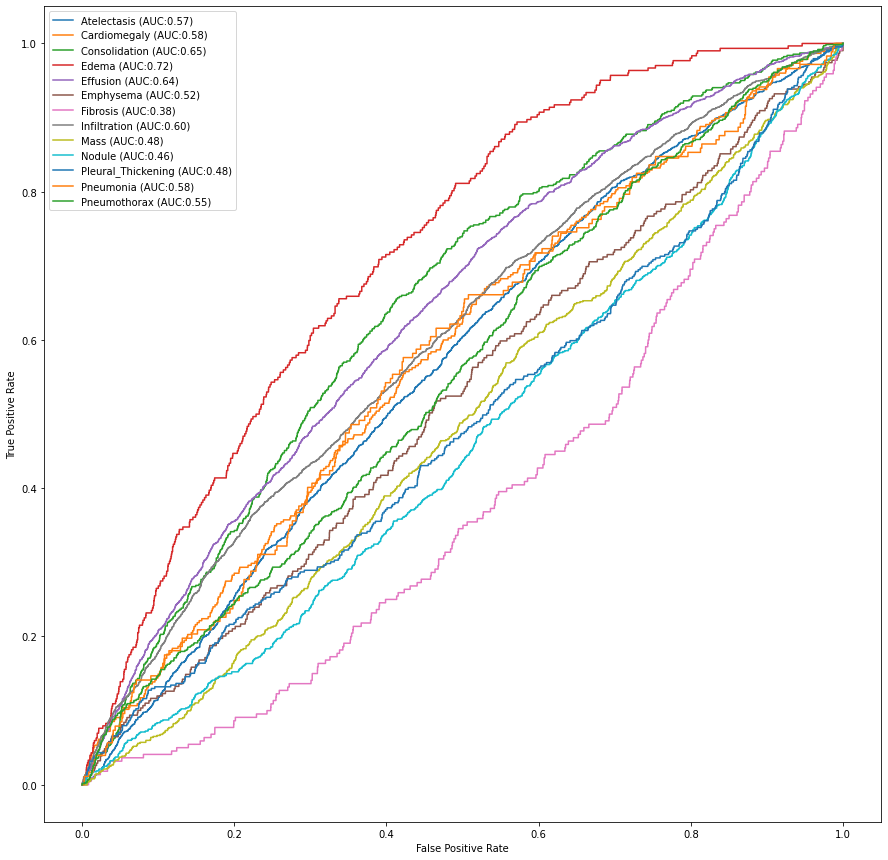

In [32]:
# Create an AUC / ROC curve 
fig, c_ax = plt.subplots(1,1, figsize = (15, 15))

# Loop through all the labels and get the index and values. 
for (idx, c_label) in enumerate(labels):
    # create variables for the roc curve based on its output.
    #The for loop loops through all the values in the list of binarized labels based on index via column of the labels
    fpr, tpr, thresholds = roc_curve(nptest_Y[:,idx].astype(int), pred_y[:,idx])
    c_ax.plot(fpr, tpr, label = '%s (AUC:%0.2f)'  % (c_label, auc(fpr, tpr)))
c_ax.legend()
c_ax.set_xlabel('False Positive Rate')
c_ax.set_ylabel('True Positive Rate')
fig.savefig('beta_20epochs.png')

In [33]:
# See Predictions greater than 20% for the provisional model and save to csv
predictions = (pred_y > 0.2).astype(int)
columns=labels
#columns should be the same order of y_col
results=pd.DataFrame(predictions, columns=columns)
results["Filenames"]=test_set["Image Index"].tolist()
ordered_cols=["Filenames"]+columns
results=results[ordered_cols]#To get the same column order
results.to_csv('beta_net_predictions.csv')

print(results)

             Filenames  Atelectasis  Cardiomegaly  Consolidation  Edema  \
0     00026810_022.png            0             0              0      0   
1     00020936_000.png            0             0              0      0   
2     00022993_023.png            0             0              0      0   
3     00005822_004.png            0             0              0      0   
4     00011470_005.png            0             0              0      0   
...                ...          ...           ...            ...    ...   
9995  00027138_000.png            0             0              0      0   
9996  00023040_000.png            0             0              0      0   
9997  00002300_005.png            0             0              0      0   
9998  00013992_030.png            0             0              0      0   
9999  00016743_018.png            0             0              0      0   

      Effusion  Emphysema  Fibrosis  Infiltration  Mass  Nodule  \
0            0          0       

In [34]:
# Required to save models in HDF5 format
!pip install pyyaml h5py

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [35]:
# Save the entire model to a HDF5 file.
# The '.h5' extension indicates that the model should be saved to HDF5.
b_model.save('b20_model.h5') 

In [36]:
# Save Model as a JSON file 
model_json = b_model.to_json()
with open("b_model.json", "w") as json_file:
    json_file.write(model_json)

### Confusion Matrices for each Individual Label

In [37]:
# Import Dependencies 
from sklearn.metrics import multilabel_confusion_matrix, ConfusionMatrixDisplay, f1_score

In [38]:
# Calculate the F1 Score for the model for multilabel classification. Use average = 'micro'
f1_score(y_true = nptest_Y, y_pred= np.array(results[labels], dtype = int), average= 'micro')

0.2734506872437907

In [39]:
# Create the confusion matrix for each of the labels 
conf_mat = multilabel_confusion_matrix(y_true = nptest_Y, y_pred= np.array(results[labels], dtype = int))

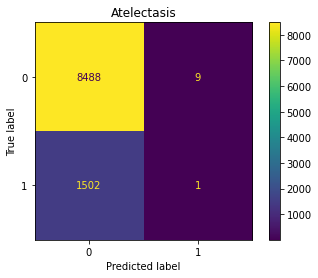

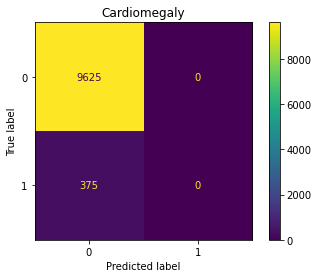

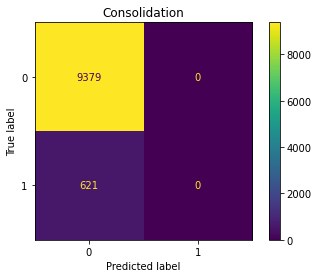

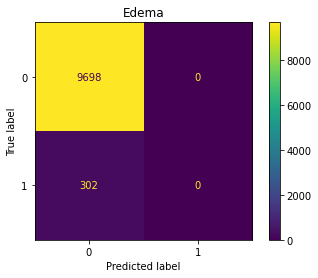

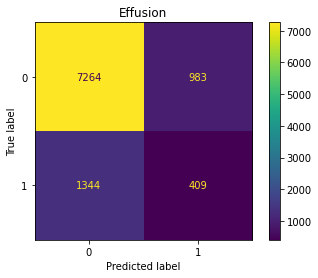

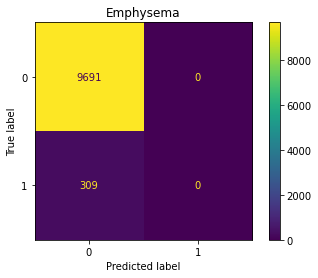

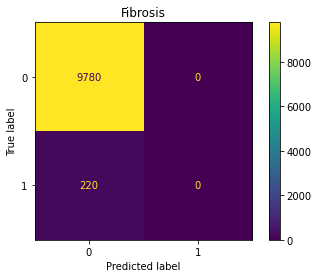

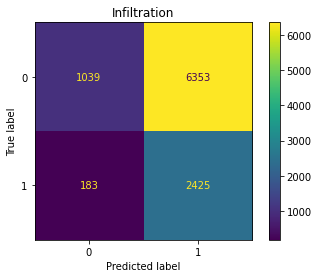

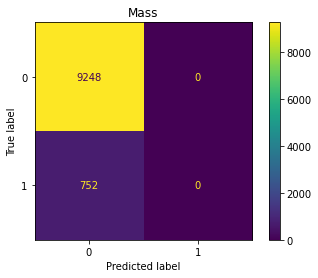

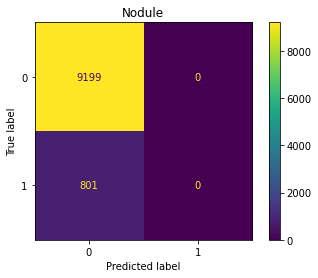

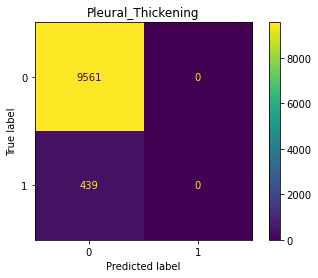

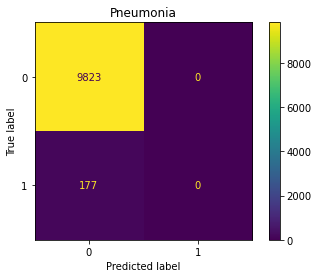

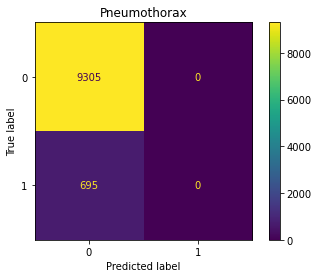

In [40]:
# Plot the individual confusion matrices for the test sample. 

for i in range(len(conf_mat)):
  disp = ConfusionMatrixDisplay(confusion_matrix=conf_mat[i])
  disp.plot()
  plt.title(labels[i])
  plt.savefig(f"cm_{labels[i]}")
  plt.show()
  